# Importing Packages

In [1]:
import sys
import pandas as pd
import math
import numpy as np

import matplotlib
from matplotlib import pyplot as plt
from matplotlib import style
import seaborn as sns

import sklearn
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
#from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
import xgboost
from xgboost import XGBRegressor

import datetime
from dateutil.relativedelta import relativedelta

In [2]:
#python package version information
print('Python version: {}'.format(sys.version))
print('NumPy version: {}'.format(np.__version__))
print('Pandas version: {}'.format(pd.__version__))
print('Matplotlib version: {}'.format(matplotlib.__version__))
print('Seaborn version: {}'.format(sns.__version__))
print('Scikit-learn version: {}'.format(sklearn.__version__))
print('XGBoost version: {}'.format(xgboost.__version__))

Python version: 3.7.13 (default, Apr 24 2022, 01:04:09) 
[GCC 7.5.0]
NumPy version: 1.21.6
Pandas version: 1.3.5
Matplotlib version: 3.2.2
Seaborn version: 0.11.2
Scikit-learn version: 1.0.2
XGBoost version: 0.90


# Data Preprocessing

In [3]:
oildf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=crude-oil-brent&months=360")[1]
coaldf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=coal-australian&months=360")[1]
gasdf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=natural-gas&months=360")[4]
sugardf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=sugar&months=360")[4]
oredf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=iron-ore&months=360")[1]
copperdf = pd.read_html("https://www.indexmundi.com/commodities/?commodity=copper&months=360")[4]

In [4]:
oildf.drop('Change', inplace = True, axis = 1)
coaldf.drop('Change', inplace = True, axis = 1)
gasdf.drop('Change', inplace = True, axis = 1)
sugardf.drop('Change', inplace = True, axis = 1)
oredf.drop('Change', inplace = True, axis = 1)
copperdf.drop('Change', inplace = True, axis = 1)

In [5]:
oildf.rename(columns = {'Price': 'oil_price'}, inplace = True)
coaldf.rename(columns = {'Price': 'coal_price'}, inplace = True)
gasdf.rename(columns = {'Price': 'gas_price'}, inplace = True)
sugardf.rename(columns = {'Price': 'sugar_price'}, inplace = True)
oredf.rename(columns = {'Price': 'ore_price'}, inplace = True)
copperdf.rename(columns = {'Price': 'copper_price'}, inplace = True)

In [6]:
df = (oildf.merge(coaldf).merge(gasdf).merge(sugardf).merge(oredf).merge(copperdf))
df.index = pd.to_datetime(df['Month'], format='%b %Y')
df.drop('Month', inplace = True, axis = 1)
odf = df.copy()
df

,oil_price,coal_price,gas_price,sugar_price,ore_price,copper_price
Month,,,,,,
1992-03-01,17.60,39.50,1.28,0.18,33.10,2227.33
1992-04-01,18.95,39.50,1.47,0.21,33.10,2215.33
1992-05-01,19.90,39.50,1.59,0.21,33.10,2216.52
1992-06-01,21.15,39.50,1.56,0.23,33.10,2299.20
1992-07-01,20.25,39.50,1.75,0.23,33.10,2520.32
...,...,...,...,...,...,...
2021-09-01,74.60,185.69,5.11,0.43,124.52,9324.71
2021-10-01,83.65,224.51,5.48,0.42,122.91,9829.22
2021-11-01,80.77,157.48,5.02,0.43,96.24,9728.90


# forecast_out

In [7]:
forecast_out = 12
df.drop(index=df.index[-forecast_out:], axis=0, inplace=True)
df

,oil_price,coal_price,gas_price,sugar_price,ore_price,copper_price
Month,,,,,,
1992-03-01,17.60,39.50,1.28,0.18,33.10,2227.33
1992-04-01,18.95,39.50,1.47,0.21,33.10,2215.33
1992-05-01,19.90,39.50,1.59,0.21,33.10,2216.52
1992-06-01,21.15,39.50,1.56,0.23,33.10,2299.20
1992-07-01,20.25,39.50,1.75,0.23,33.10,2520.32
...,...,...,...,...,...,...
2020-09-01,41.09,54.60,1.92,0.28,123.75,6704.90
2020-10-01,40.47,58.40,2.25,0.30,119.78,6713.81
2020-11-01,43.23,64.40,2.59,0.31,124.36,7068.91


# Dataset Analysis

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 347 entries, 1992-03-01 to 2021-01-01
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   oil_price     347 non-null    float64
 1   coal_price    347 non-null    float64
 2   gas_price     347 non-null    float64
 3   sugar_price   347 non-null    float64
 4   ore_price     347 non-null    float64
 5   copper_price  347 non-null    float64
dtypes: float64(6)
memory usage: 19.0 KB


In [9]:
df.describe()

,oil_price,coal_price,gas_price,sugar_price,ore_price,copper_price
count,347.000000,347.000000,347.000000,347.000000,347.000000,347.000000
mean,51.057291,59.673862,3.823573,0.286427,70.155274,4514.420576
std,32.669198,31.081673,2.161832,0.113004,47.063346,2472.007299
min,9.800000,22.250000,1.280000,0.110000,26.470000,1377.280000
25%,20.705000,33.270000,2.270000,0.210000,30.030000,1973.370000
50%,45.560000,52.210000,3.020000,0.270000,60.890000,4576.780000
75%,71.475000,82.050000,4.635000,0.340000,93.675000,6823.205000
max,133.870000,180.000000,13.520000,0.650000,197.120000,9867.600000


In [10]:
continuous_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
print(continuous_features)

['oil_price', 'coal_price', 'gas_price', 'sugar_price', 'ore_price', 'copper_price']


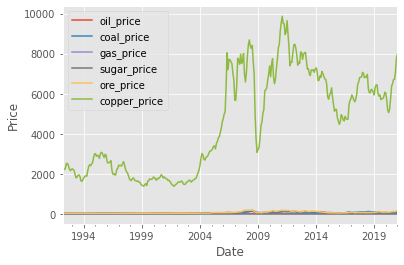

In [11]:
style.use('ggplot')
df.plot(y = continuous_features)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

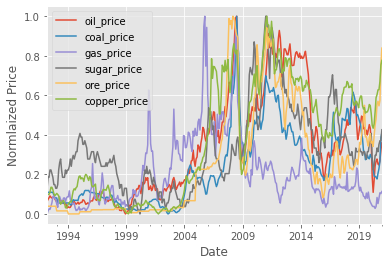

In [12]:
df_min_max_scaled = df.copy()
for column in df:
    df_min_max_scaled[column] = (df_min_max_scaled[column] - df_min_max_scaled[column].min()) / (df_min_max_scaled[column].max() - df_min_max_scaled[column].min())
df_min_max_scaled.plot(y = continuous_features)
plt.xlabel('Date')
plt.ylabel('Normlaized Price')
plt.show()

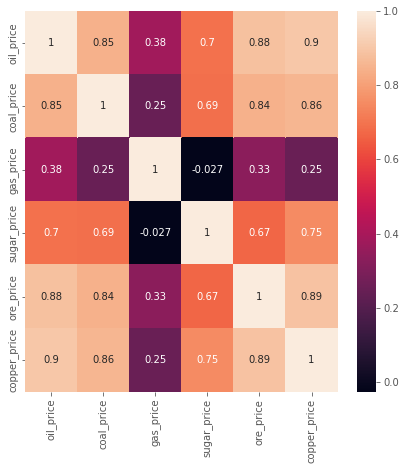

In [13]:
cor_mat = df.corr()
fig = plt.figure(figsize=(7, 7))
sns.heatmap(cor_mat,annot = True)
plt.show()

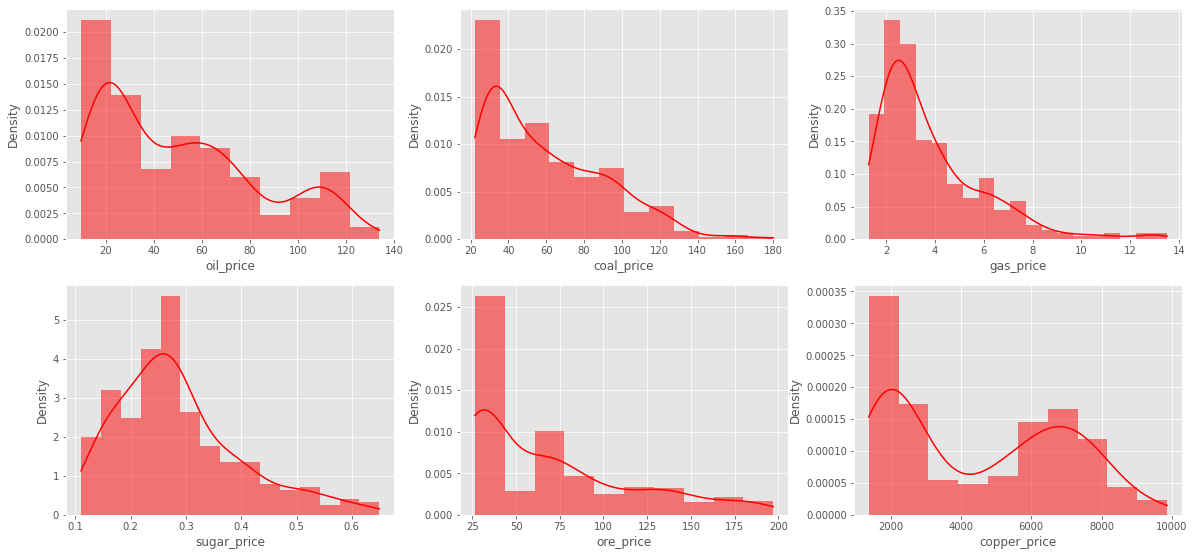

In [14]:
plt.figure(figsize=(20, 60))
plotnumber = 1
for feature in continuous_features:
    ax = plt.subplot(12, 3, plotnumber)
    sns.histplot(df[feature], color = "red", kde = True, stat = "density", linewidth = 0)
    plotnumber+=1
plt.show()

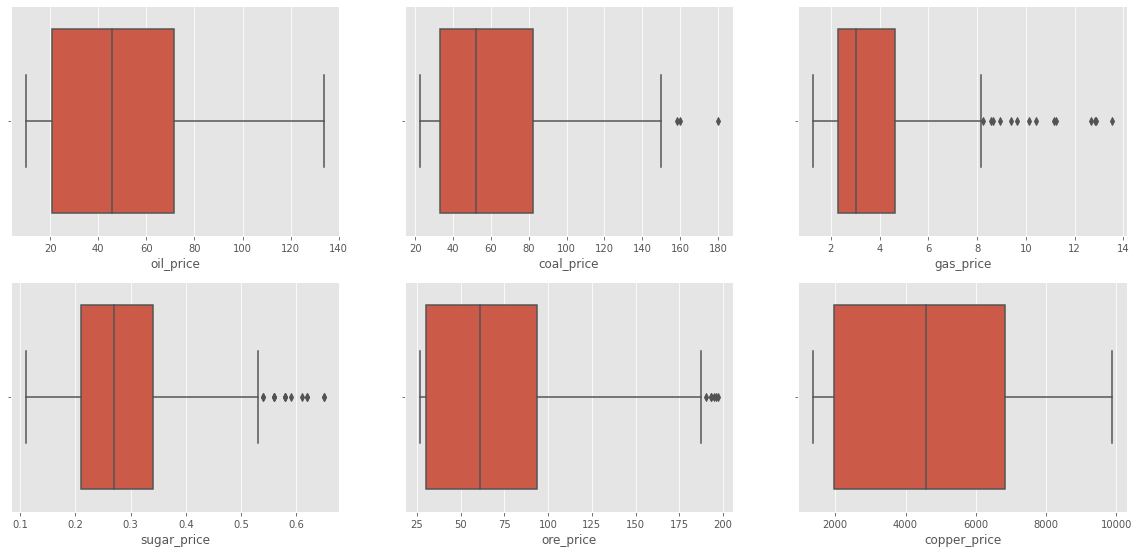

In [15]:
plt.figure(figsize=(20, 60))
plotnumber = 1
for feature in continuous_features:
    ax = plt.subplot(12, 3, plotnumber)
    sns.boxplot(x = df[feature])
    plt.xlabel(feature)
    plotnumber+=1
plt.show()

# Selecting Best Model

In [16]:
def find_best_model_using_gridsearchcv(x, y):
    algos = {
        'DecisionTreeRegressor': {
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['squared_error','friedman_mse'],
                'splitter': ['best']
            }
        },
        'RandomForestRegressor': {
            'model': RandomForestRegressor(),
            'params': {
                'n_estimators': [10, 50, 100, 130],
                'criterion': ['squared_error'],
                'max_depth': range(2, 4, 1),
                'max_features': ['auto','log2']
            }
        },
        'XGBRegressor': {
            'model': XGBRegressor(),
            'params': {
                'objective': ['reg:squarederror'],
                'learning_rate': [0.5, 0.1, 0.01, 0.001],
                'max_depth': [2, 3],
                'n_estimators': [10, 50, 100, 200]
            }
        },
        'LinearRegression': {
            'model': LinearRegression(),
            'params': {}
        }

    }
    scores = []
    #cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 0)
    cv = TimeSeriesSplit(n_splits = 5, test_size = 12)
    for algo_name, config in algos.items():
        gs = GridSearchCV(config['model'], config['params'], cv = cv, return_train_score = False)
        gs.fit(x,y)
        scores.append({
            'model':algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores, columns = ['model', 'best_score', 'best_params'])

# Price Predictions by Combined Dataset

# Target

In [17]:
target = 'coal_price' #oil_price, coal_price, gas_price, sugar_price, ore_price, copper_price

# Anyalysis

In [18]:
print(cor_mat[target])

oil_price       0.847537
coal_price      1.000000
gas_price       0.248950
sugar_price     0.690429
ore_price       0.844155
copper_price    0.859647
Name: coal_price, dtype: float64


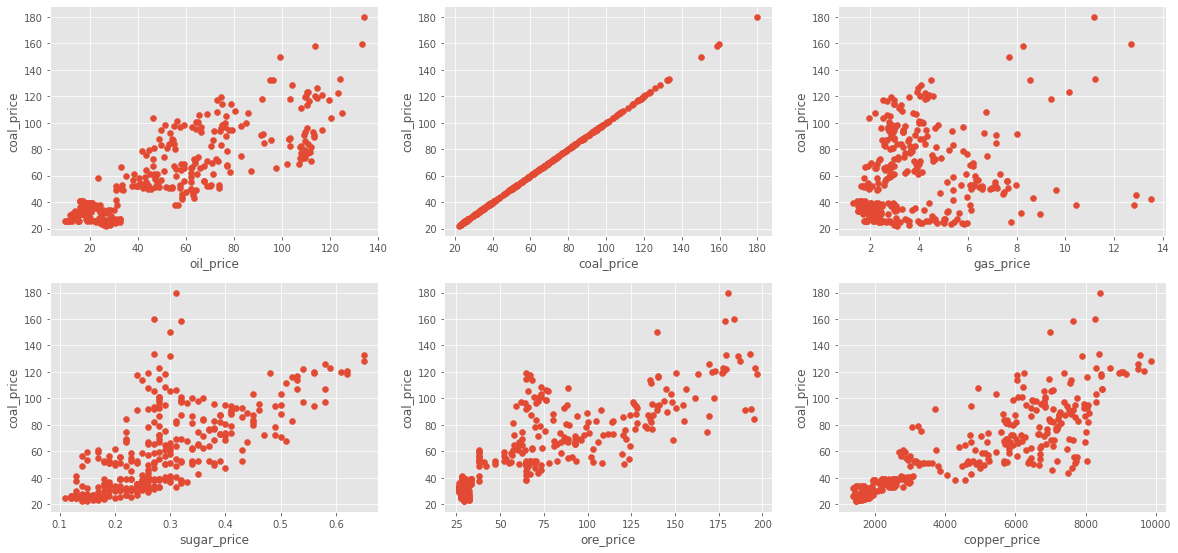

In [19]:
plt.figure(figsize=(20, 60))
plotnumber = 1
for feature in continuous_features:
    ax = plt.subplot(12, 3, plotnumber)
    plt.scatter(df[feature], df[target])
    plt.xlabel(feature)
    plt.ylabel(target)
    plotnumber+=1
plt.show()

# Preprocessing

In [20]:
df['Y'] = df[target].shift(-forecast_out)
df

,oil_price,coal_price,gas_price,sugar_price,ore_price,copper_price,Y
Month,,,,,,,
1992-03-01,17.60,39.50,1.28,0.18,33.10,2227.33,31.0
1992-04-01,18.95,39.50,1.47,0.21,33.10,2215.33,31.0
1992-05-01,19.90,39.50,1.59,0.21,33.10,2216.52,31.0
1992-06-01,21.15,39.50,1.56,0.23,33.10,2299.20,31.0
1992-07-01,20.25,39.50,1.75,0.23,33.10,2520.32,31.0
...,...,...,...,...,...,...,...
2020-09-01,41.09,54.60,1.92,0.28,123.75,6704.90,NaN
2020-10-01,40.47,58.40,2.25,0.30,119.78,6713.81,NaN
2020-11-01,43.23,64.40,2.59,0.31,124.36,7068.91,NaN


In [21]:
X = np.array(df.drop(['Y'], 1))
X = preprocessing.scale(X)
X_lately = X[-forecast_out:]
X = X[:-forecast_out]
print(len(X))
X

335


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.


array([[-1.02560232, -0.64999698, -1.17828156, -0.94315611, -0.78848586,
        -0.92653174],
       [-0.98421932, -0.64999698, -1.09026621, -0.67729489, -0.78848586,
        -0.93139311],
       [-0.95509795, -0.64999698, -1.03467757, -0.67729489, -0.78848586,
        -0.93091102],
       ...,
       [ 0.35812264,  0.23572422, -0.55290937, -0.05695202,  0.31545003,
         0.54509241],
       [ 0.45345681,  0.20962622, -0.75210199,  0.1202888 ,  0.4786572 ,
         0.63304665],
       [ 0.38448514,  0.32175098, -0.83548495,  0.20890921,  0.54483377,
         0.61447219]])

In [22]:
y = np.array(df['Y'])
y = y[:-forecast_out]
print(len(y))
y

335


array([ 31.  ,  31.  ,  31.  ,  31.  ,  31.  ,  31.  ,  31.  ,  31.  ,
        31.  ,  31.  ,  31.  ,  31.  ,  29.5 ,  29.5 ,  31.4 ,  33.6 ,
        33.1 ,  33.1 ,  33.1 ,  33.1 ,  33.1 ,  36.1 ,  37.1 ,  37.6 ,
        38.35,  37.1 ,  38.77,  40.77,  41.05,  40.88,  40.93,  40.97,
        39.59,  39.35,  39.37,  39.28,  39.01,  39.33,  38.2 ,  38.2 ,
        38.4 ,  38.35,  38.1 ,  37.6 ,  35.7 ,  35.35,  35.23,  34.6 ,
        34.5 ,  35.4 ,  35.73,  34.5 ,  35.  ,  36.93,  37.15,  37.15,
        33.6 ,  31.4 ,  31.4 ,  33.44,  31.88,  31.18,  30.28,  30.  ,
        30.  ,  26.2 ,  27.09,  27.1 ,  26.1 ,  26.1 ,  26.1 ,  26.1 ,
        26.1 ,  26.1 ,  26.1 ,  26.1 ,  26.1 ,  26.1 ,  26.1 ,  25.6 ,
        25.1 ,  25.1 ,  25.1 ,  25.1 ,  25.1 ,  25.1 ,  25.6 ,  25.6 ,
        25.6 ,  25.6 ,  27.15,  27.15,  27.15,  30.75,  32.1 ,  32.1 ,
        32.6 ,  33.5 ,  33.8 ,  33.9 ,  34.  ,  33.8 ,  32.8 ,  32.4 ,
        29.4 ,  27.35,  27.35,  28.1 ,  27.8 ,  27.09,  26.88,  24.9 ,
      

# GridsearchCV result

In [23]:
pd.set_option('display.max_colwidth', 100)
find_best_model_using_gridsearchcv(X,y)

,model,best_score,best_params
0,DecisionTreeRegressor,-9.347812,"{'criterion': 'squared_error', 'splitter': 'best'}"
1,RandomForestRegressor,-3.269071,"{'criterion': 'squared_error', 'max_depth': 2, 'max_features': 'log2', 'n_estimators': 50}"
2,XGBRegressor,-4.583160,"{'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 50, 'objective': 'reg:squarederror'}"
3,LinearRegression,-2.962934,{}


# Model

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.03, shuffle=False)

In [25]:
#clf = RandomForestRegressor(criterion =  'squared_error', max_depth = 2, n_estimators = 50, max_features = 'log2')
#clf = XGBRegressor(learning_rate = 0.01, max_depth = 2, n_estimators = 200, objective = 'reg:squarederror')
clf = LinearRegression()
clf.fit(X_train, y_train)
confidence = clf.score(X_test, y_test)
print(confidence)

-1.549993655327349


In [26]:
forecast_set = clf.predict(X_lately)
df['Forecast'] = np.nan
forecast_set

array([ 77.6906728 ,  85.53496373,  88.743349  ,  86.01379079,
        88.32410686,  96.01276241,  99.35692115, 104.98883761,
       106.55605104, 111.83399727, 123.4521227 , 125.85572631])

In [27]:
for i in forecast_set:
    next_date = df.iloc[-1].name + relativedelta(months=1)
    df.loc[next_date] = [np.nan for _ in range(len(df.columns)-1)]+[i]

In [28]:
df

,oil_price,coal_price,gas_price,sugar_price,ore_price,copper_price,Y,Forecast
Month,,,,,,,,
1992-03-01,17.60,39.5,1.28,0.18,33.1,2227.33,31.0,NaN
1992-04-01,18.95,39.5,1.47,0.21,33.1,2215.33,31.0,NaN
1992-05-01,19.90,39.5,1.59,0.21,33.1,2216.52,31.0,NaN
1992-06-01,21.15,39.5,1.56,0.23,33.1,2299.20,31.0,NaN
1992-07-01,20.25,39.5,1.75,0.23,33.1,2520.32,31.0,NaN
...,...,...,...,...,...,...,...,...
2021-09-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,104.988838
2021-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,106.556051
2021-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,111.833997


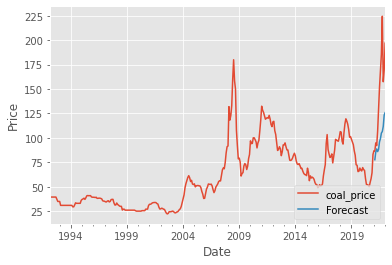

In [29]:
odf[target].plot()
df['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

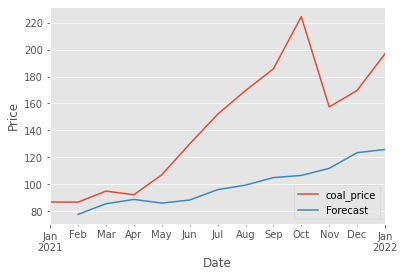

In [30]:
odf.tail(forecast_out+1)[target].plot()
df.tail(forecast_out)['Forecast'].plot()
plt.legend(loc=4)
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

In [31]:
print(df['Forecast'])

Month
1992-03-01           NaN
1992-04-01           NaN
1992-05-01           NaN
1992-06-01           NaN
1992-07-01           NaN
                 ...    
2021-09-01    104.988838
2021-10-01    106.556051
2021-11-01    111.833997
2021-12-01    123.452123
2022-01-01    125.855726
Name: Forecast, Length: 359, dtype: float64


In [32]:
print(odf[target])

Month
1992-03-01     39.50
1992-04-01     39.50
1992-05-01     39.50
1992-06-01     39.50
1992-07-01     39.50
               ...  
2021-09-01    185.69
2021-10-01    224.51
2021-11-01    157.48
2021-12-01    169.65
2022-01-01    196.95
Name: coal_price, Length: 359, dtype: float64
